In [4]:
import os

import pandas as pd
import numpy as np

from scipy.interpolate import UnivariateSpline

import statsmodels as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt

In [5]:
whole_stats = pd.read_csv("csvs/whole_stats.csv")
whole_stats.rename(lambda n:f"sensor_{n+1}", inplace=True)
whole_stats

,count,mean,std,min,max
sensor_1,265864431.0,0.025250,203.303099,-1171.0,1278.0
sensor_2,265864431.0,-0.431776,418.222197,-4759.0,4118.0
sensor_3,265864431.0,0.233829,178.179004,-1288.0,1212.0
sensor_4,265864431.0,0.281562,200.602547,-1280.0,1532.0
sensor_5,265864431.0,-0.000650,161.583577,-1225.0,1370.0
sensor_6,265864431.0,0.044916,299.005016,-3226.0,2575.0
sensor_7,265864431.0,4.590190,204.956910,-986.0,983.0
sensor_8,265864431.0,-2.975500,247.542130,-934.0,1060.0
sensor_9,265864431.0,2.170547,196.562165,-1210.0,1316.0
sensor_10,265864431.0,-120.953801,937.478541,-3743.0,3229.0


# Análisis de series de tiempo

![](imgs/amps-1.png)

## Tendencia

En este caso es cero, porque la media no cambia con el tiempo (o sea no va subiendo y/o bajando)


## Periodicidad

Se puede encontrar con una gráfica de autocorrelación. Consiste en calcular la correlación respecto los datos y estos mismo pero desplazados una cierta cantidad de unidades en el tiempo. Correlaciones altas indican posibles periodos

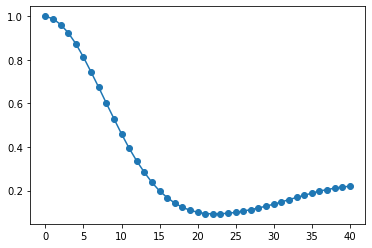

In [70]:
autocorrelation = stattools.acf(df.sensor_1, nlags=40, fft=False)

plt.plot(autocorrelation)
plt.scatter(np.arange(0,41), autocorrelation)

In [71]:
higher_correlation = np.sort(autocorrelation)[-2]
np.argwhere(autocorrelation == higher_correlation).squeeze()

array(1)

In [72]:
serie1 = df.sensor_1
train, test = serie1.iloc[:40000], serie1.iloc[40000:]

In [83]:
holtwinters = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=2, 
                                   initialization_method="estimated").fit(optimized=True)

In [81]:
pred = holtwinters.predict(start=test.index[0], end=test.index[-1])

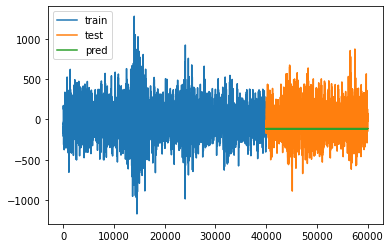

In [82]:
plt.plot(train.index,train, label="train")
plt.plot(test.index,test,label="test")
plt.plot( pred, label="pred")
#plt.xlim((3000,3500))
#plt.ylim((-10,10))
plt.legend()

In [2]:
from time import time

In [63]:
train_filenames = os.listdir("train")
train_filenames = [filename for filename in train_filenames if ".csv" in filename]

df = pd.read_csv("train/"+train_filenames[11])
#df.head()

df.isna().sum(axis=0)

sensor_1        0
sensor_2        0
sensor_3        0
sensor_4        0
sensor_5     2880
sensor_6        0
sensor_7        0
sensor_8        0
sensor_9        0
sensor_10       0
dtype: int64

# Imputación de los valores faltantes

La estrategia original, pero posiblemente la que no se usará

* Si el sensor carece de **todos** los valores, rellenar con la media
* De lo contrario
    * Si hay valores nulos en los primeras observaciones, rellenar con la media
    * Identificar índice del primer dato que no es nulo en la serie. Lo mismo para el último. Si hay nulos de por medio, rellenar con una **interpolación** por splines
    * Para el resto de nulos, rellenarlos por media de un modelo de Holt - Winters

In [25]:
def impute_df(df, whole_stats):
    nrows, ncols = df.shape
    nans_per_sensor = df.isna().sum(axis=0)
    for sensor in df.columns:
        n_nans = nans_per_sensor[sensor]
        data = df[sensor].values
        if n_nans == nrows or n_nans/n_rows < 0.5: 
            sensor_mean = whole_stats.loc[sensor,"mean"]
            df[sensor].fillna(sensor_mean, inplace=True)
        elif 0 < n_nans: # some values are missing
            t0 = time()
            not_nan_indexes = np.argwhere(~np.isnan(data)).squeeze()
            first_not_nan_index = not_nan_indexes[0]
            last_not_nan_index = not_nan_indexes[-1]
            if first_not_nan_index != 0:  # imputing first values with mean
                data[:first_not_nan_index] = whole_stats.loc[sensor,"mean"]
            print("Imputed first part", time() - t0)
                
            if not_nan_indexes[1:-1].size > 2:  # Imputing with interpolation
                t0 = time()
                nan_mask = np.isnan(data)
                not_nan_indexes = np.argwhere(~nan_mask).squeeze()
                #print(not_nan_indexes.shape)
                #print(data[~nan_mask].shape)
                xp = not_nan_indexes
                yp = data[~nan_mask]
                spline = UnivariateSpline(xp,yp, k=2)
                x_interp = np.argwhere(nan_mask).squeeze()
                y_interp = spline(x_interp)
                data[nan_mask] = y_interp
                print("interpolated", time() - t0)
            
            if last_not_nan_index != nrows: # Imputing with holt-winters model
                t0 = time()
                nan_mask = np.isnan(data)
                autocorrelation = stattools.acf(data[~nan_mask], nlags=40, fft=False)
                higher_correlation = np.sort(autocorrelation)[-2]
                period = np.argwhere(autocorrelation == higher_correlation).squeeze() + 1
                holtwinters = ExponentialSmoothing(data[~nan_mask], trend=None, seasonal="add", 
                                                   seasonal_periods=period, 
                                                   initialization_method="estimated").fit(optimized=True)
                #print(last_not_nan_index)
                forecasting = holtwinters.predict(start=last_not_nan_index+1, end=nrows-1)
                #print(forecasting.shape)
                #print(nan_mask.sum())
                data[last_not_nan_index+1:] = forecasting
                print("forecasted", time() - t0)

        else: # There are no nans
            pass
        df[sensor] = data
        
    return df

El problema estriba principalmente en que si la serie tiene pocos datos faltantes y estos se encuentren de por medio, se imputarán por interpolación, y encontrar los splines para la gran cantidad de puntos toma hasta 3 minutos por sensor. 

-----------
# Imputando datos (más rápido)

La implementación pasada es mejor, pero hay algunos casos donde se tardaba bastante, haciendolo posiblemente no viable

La implementación que se presenta es más sencilla, la estrategia para rellenar nulos es la siguiente:

Primeramente se imputa con la media de `whole_stats.csv`.
* Si el sensor carece de **todos** los valores, pues se rellena todo
* De lo contrario, se llena algunos nulos de tal manera que se pueda dividir la serie en dos partes contiguas: no nulos y nulos (en ese orden). Los nulos restantes se estiman con un modelo de Holt - Winters.

In [64]:
def impute_df(df, whole_stats):
    nrows, ncols = df.shape
    nans_per_sensor = df.isna().sum(axis=0)
    for sensor in df.columns:
        n_nans = nans_per_sensor[sensor]
        if n_nans:
            mean = whole_stats.loc[sensor,"mean"]
            if n_nans == nrows:
                df[sensor].fillna(mean, inplace=True)
    
            else:
                data = df[sensor].values
                nan_mask = np.isnan(data)
                not_nan_indexes = np.argwhere(~nan_mask).squeeze()
                first_not_nan_index = not_nan_indexes[0]
                last_not_nan_index = not_nan_indexes[-1]
                nans_batch1 = nan_mask.copy()
                nans_batch1[last_not_nan_index+1:] = False
                data[nans_batch1] = mean
                
                # holt winters
                if last_not_nan_index != nrows-1:
                    #print(first_not_nan_index,last_not_nan_index)
                    autocorrelation = stattools.acf(data[:last_not_nan_index], nlags=40, fft=False)
                    higher_correlation = np.sort(autocorrelation)[-2]
                    period = np.argwhere(autocorrelation == higher_correlation).squeeze() + 1
                    holtwinters = ExponentialSmoothing(data[:last_not_nan_index], trend=None, seasonal="add", 
                                                       seasonal_periods=period, 
                                                       initialization_method="estimated").fit(optimized=True)
                    #print(last_not_nan_index)
                    forecasting = holtwinters.predict(start=last_not_nan_index+1, end=nrows-1)
                    #print(forecasting.shape)
                    #print(nan_mask.sum())
                    data[last_not_nan_index+1:] = forecasting
    
                df[sensor] = data
        
    return df

In [56]:
%%time
df2 = impute_df(df, whole_stats)

CPU times: user 9.93 ms, sys: 7 µs, total: 9.94 ms
Wall time: 7.74 ms


In [66]:
%%time
for i,filename in enumerate(train_filenames,1):
    if i%100 == 0:
        print("file",i)
    df = pd.read_csv("train/"+filename)
    df2 = impute_df(df,whole_stats)

/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 100


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 200


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 300


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 400


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 500


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 600


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dant

file 700


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 800


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 900


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1000


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1100


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1200


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1300
file 1400


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1500


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1600
file 1700


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1800


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 1900


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2000


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2100
file 2200


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2300


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2400


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2500


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2600


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2700


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dant

file 2800


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 2900


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dant

file 3000


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3100


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3200


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3300


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3400


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3500


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dant

file 3600


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3700


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 3800


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dant

file 3900


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 4000


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 4100


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 4200


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 4300


/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/dante/miniconda3/envs/datamining/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


file 4400
CPU times: user 30min 38s, sys: 42.1 s, total: 31min 20s
Wall time: 9min 2s
